In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools # Importando itertools para generar combinaciones de columnas
# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
import payments_manager as pm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#pm.help()
#pm.reset()
#pm.init() #debug=True)
cr_cp = pm.df('cr_cp')
fe_cp = pm.df('fe_cp')
#cr_cp.info()
#fe_cp.info()

df_jo = pm.df('df_jo')
#df_jo.info()
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])

#df_jo = df_jo.drop(columns=['Mes_created_at'])
df_jo_cp = df_jo.copy()

df_jo_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32092 entries, 0 to 32091
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   id_cr                       32092 non-null  int64          
 1   id_fe                       32092 non-null  int64          
 2   fe_cr_id                    21055 non-null  float64        
 3   user_id                     32092 non-null  int64          
 4   active                      32092 non-null  int64          
 5   created_at                  32092 non-null  datetime64[ns] 
 6   created_at_fe               21055 non-null  datetime64[ns] 
 7   amount                      32092 non-null  float64        
 8   fee                         32092 non-null  float64        
 9   stat_cr                     32092 non-null  object         
 10  stat_fe                     32092 non-null  object         
 11  transfer_type               32092 non-nul

In [2]:
df_transformado = df_jo_cp.copy()

# Convertir columnas datetime a timestamps
for col in df_transformado.select_dtypes(include=['datetime64']).columns:
    df_transformado[col] = df_transformado[col].apply(lambda x: x.timestamp() if pd.notnull(x) else None)
    
# Convertir columnas slot en enteros
df_transformado['created_at_slot'] = pd.to_numeric(df_transformado['created_at_slot'], errors='coerce').astype('Int64')
df_transformado['created_at_dow'] = pd.to_numeric(df_transformado['created_at_dow'], errors='coerce').astype('Int64')

# Reasignar valores en la columna 'transfer_type' y 'charge_moment' para convertirlo a numéricas
df_transformado = df_transformado.copy()
df_transformado['transfer_type'] = df_transformado['transfer_type'].map({'regular': 0, 'instant': 1})
df_transformado['charge_moment_numeric'] = df_transformado['charge_moment'].fillna('null').map({
    'before': 1,
    'after': 2,
    'null': 0  # Asigna 0 para los valores nulos llenados como 'null'
})
df_transformado['category'] = df_transformado['category'].fillna('null').map({'rejected': 1, 'month_delay_on_payment': 2, 'null':0})

# Descartar columna categorica
df_transformado=df_transformado.drop(columns=['charge_moment'])

# Convertir timedelta a float en días
df_transformado['to_receive_ini'] = df_transformado['to_receive_ini'] / pd.Timedelta(days=1)
df_transformado['to_receive_bank'] = df_transformado['to_receive_bank'] / pd.Timedelta(days=1)
df_transformado['to_reimbur'] = df_transformado['to_reimbur'] / pd.Timedelta(days=1)
df_transformado['to_reimbur_cash'] = df_transformado['to_reimbur_cash'] / pd.Timedelta(days=1)
df_transformado['to_end'] = df_transformado['to_end'] / pd.Timedelta(days=1)
df_transformado['to_send'] = df_transformado['to_send'] / pd.Timedelta(days=1)

# Variable categorica type a numérica
df_transformado['type'] = df_transformado['type'].fillna('null').map({
    'instant_payment': 1,
    'split_payment': 2,    
    'incident': 3 ,
    'postpone' : 4,
    'null' : 0
})

# Variable categorica recovery_Status a numérica
df_transformado['recovery_status'] = df_transformado['recovery_status'].fillna('null').map({
    'completed': 1,
    'pending': 2,    
    'pending_direct_debit': 3 ,
    'null' : 0
})

# Variable categorica stat_cr a numérica
df_transformado['stat_cr'] = df_transformado['stat_cr'].fillna('null').map({
    'approved': 1,
    'money_sent': 2,    
    'rejected': 3 ,
    'pending': 4,
    'transaction_declined': 5,
    'waiting_user_information': 6,
    'direct_debit_rejected': 7,
    'canceled': 8,
    'direct_debit_sent': 9,
    'waiting_reimbursement': 10,
    'active': 11,
    'money_back': 12,    
    'null' : 0
})

# Variable categorica stat_fe a numérica
df_transformado['stat_fe'] = df_transformado['stat_fe'].fillna('null').map({
    'confirmed': 1,
    'rejected': 2,    
    'cancelled': 3 ,
    'accepted': 4,
    'null' : 0
})

# Descartar columnas repetidas
df_transformado=df_transformado.drop(columns=['created_at_d','created_at_slot_h','Mes_created_at'])

# Descartar columnas sin interés
df_transformado=df_transformado.drop(columns=['reason'])

In [11]:
df_transformado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32092 entries, 0 to 32091
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_cr                       32092 non-null  int64  
 1   id_fe                       32092 non-null  int64  
 2   fe_cr_id                    21055 non-null  float64
 3   user_id                     32092 non-null  int64  
 4   active                      32092 non-null  int64  
 5   created_at                  32092 non-null  float64
 6   created_at_fe               21055 non-null  float64
 7   amount                      32092 non-null  float64
 8   fee                         32092 non-null  float64
 9   stat_cr                     32092 non-null  int64  
 10  stat_fe                     21055 non-null  float64
 11  transfer_type               32092 non-null  int64  
 12  type                        21055 non-null  float64
 13  to_receive_ini              253

In [3]:


# Crear el escalador
scaler = StandardScaler()
needs=df_transformado['needs_m_check_recov']
df_transformado=df_transformado.drop(columns='needs_m_check_recov')

# Estandarizar todas las columnas
normalizado = scaler.fit_transform(df_transformado)

# Convertir de nuevo a DataFrame, preservando nombres de columnas e índices
df_transformado = pd.DataFrame(normalizado, columns=df_transformado.columns, index=df_transformado.index)

df_transformado.fillna(0, inplace=True)


df_transformado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32092 entries, 0 to 32091
Data columns (total 46 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_cr                       32092 non-null  float64
 1   id_fe                       32092 non-null  float64
 2   fe_cr_id                    32092 non-null  float64
 3   user_id                     32092 non-null  float64
 4   active                      32092 non-null  float64
 5   created_at                  32092 non-null  float64
 6   created_at_fe               32092 non-null  float64
 7   amount                      32092 non-null  float64
 8   fee                         32092 non-null  float64
 9   stat_cr                     32092 non-null  float64
 10  stat_fe                     32092 non-null  float64
 11  transfer_type               32092 non-null  float64
 12  type                        32092 non-null  float64
 13  to_receive_ini              320

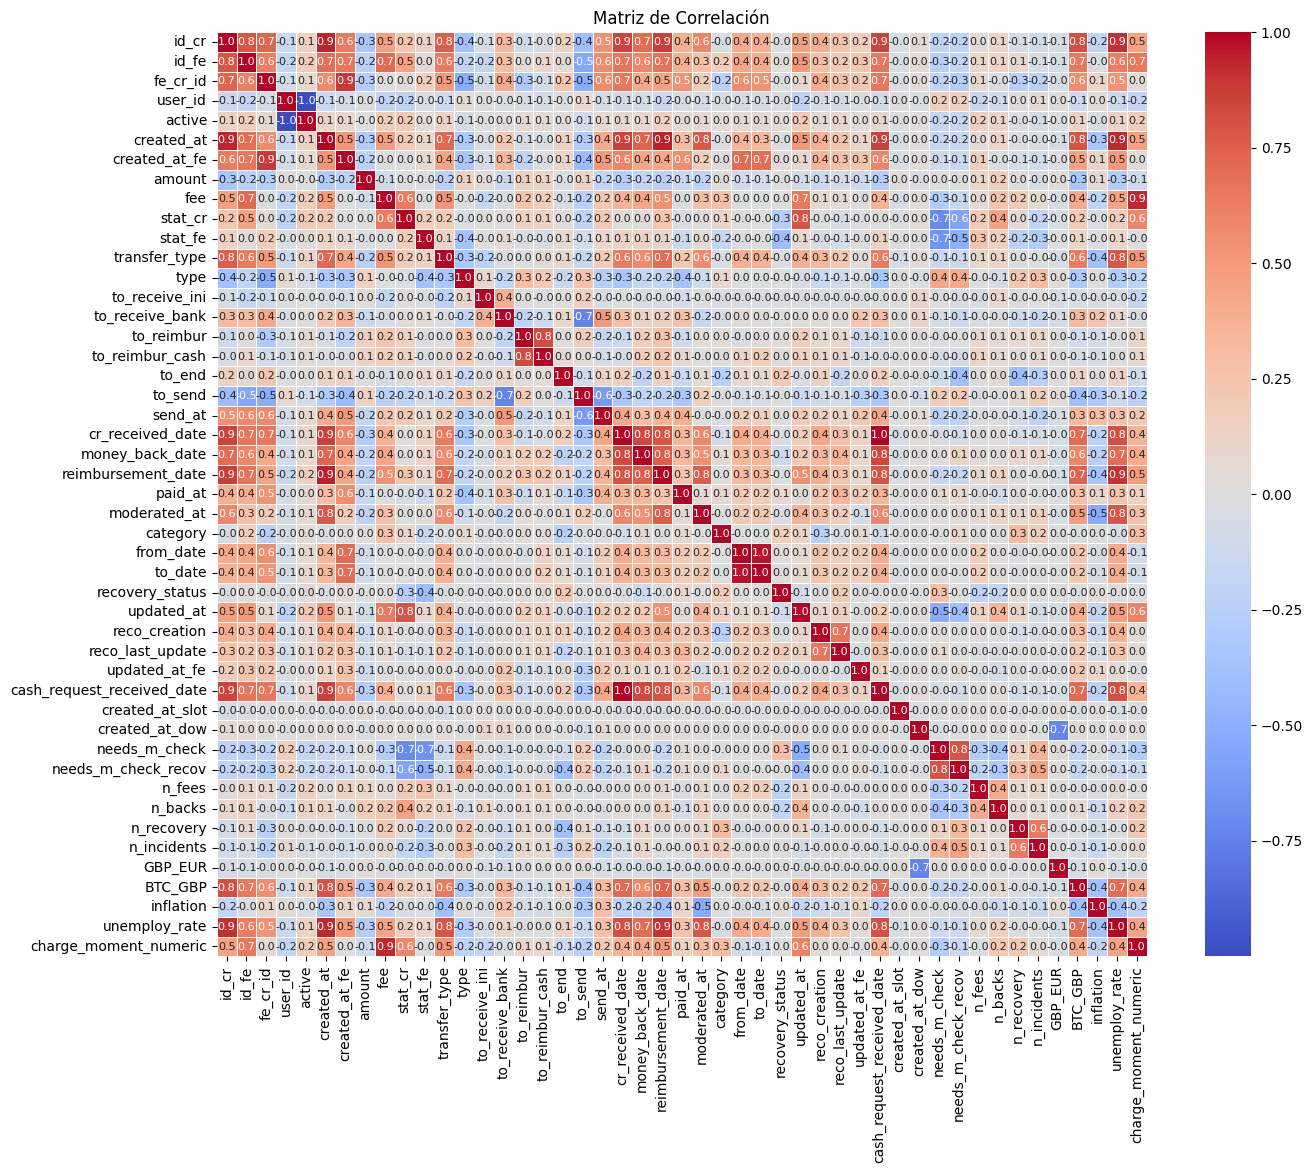

In [13]:
corr_matrix = df_transformado.corr()
# Visualizar la matriz de correlación
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.1f', linewidths=0.5, annot_kws={'size':8})
plt.title('Matriz de Correlación')
plt.show()

In [19]:
# Separación correcta de X e y
X = df_transformado[['user_id', 'stat_cr','stat_fe','amount','fee','recovery_status','GBP_EUR','inflation','BTC_GBP','unemploy_rate','created_at_slot','created_at_dow','transfer_type','charge_moment_numeric']] # Elimina la columna objetivo
y = needs  # La columna de la variable objetivo

In [20]:
# Obtener los nombres de las características
feature_names = X.columns

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")

# Entrena el clasificador
clf.fit(X_train, y_train)

# Realiza predicciones sobre el conjunto de prueba
predicciones = clf.predict(X_test)


In [21]:
# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Muestra las primeras 10 probabilidades de predicción
#predicciones_probabilidades[:10]

# Obtén los coeficientes y asigna los nombres de las características
coeficientes = clf.coef_[0]  # clf.coef_ es un array bidimensional, tomamos la primera fila
feature_coef = list(zip(feature_names, coeficientes))

# Ordena las características por el valor absoluto del coeficiente en orden descendente
feature_coef_sorted = sorted(feature_coef, key=lambda x: abs(x[1]), reverse=True)

# Imprime cada variable junto con su coeficiente ordenado
print("Coeficientes del modelo de regresión logística (ordenados por magnitud):")
for feature, coef in feature_coef_sorted:
    print(f"{feature}: {coef:.4f}")

Coeficientes del modelo de regresión logística (ordenados por magnitud):
stat_cr: -16.6522
recovery_status: -9.2940
stat_fe: -5.4171
fee: 1.8216
charge_moment_numeric: 0.8437
transfer_type: -0.4326
unemploy_rate: -0.2816
BTC_GBP: -0.2474
amount: -0.1672
inflation: -0.1526
GBP_EUR: -0.0354
user_id: 0.0331
created_at_dow: 0.0214
created_at_slot: 0.0117


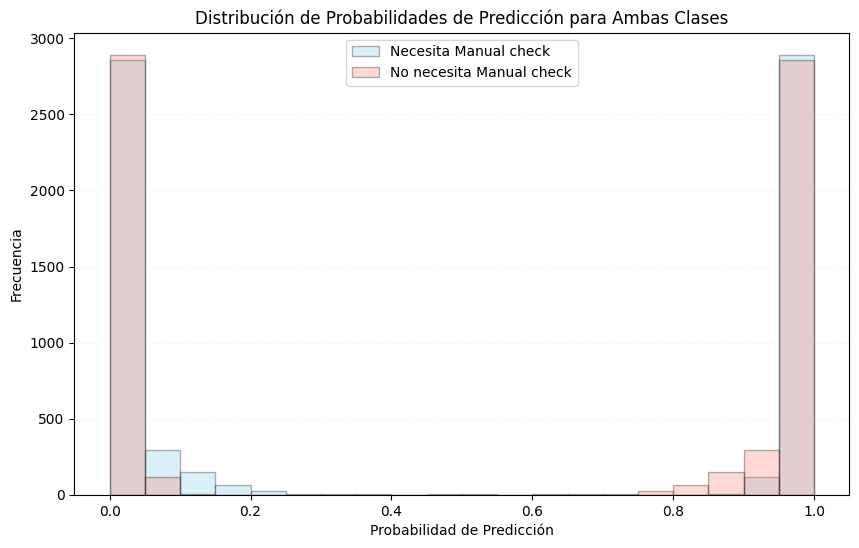

In [22]:
# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 

# # Histograma para la clase negativa (need manual check)
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Histograma para la clase positiva (no need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

Accuracy: 0.9940800747780028
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3003
           1       1.00      0.99      0.99      3416

    accuracy                           0.99      6419
   macro avg       0.99      0.99      0.99      6419
weighted avg       0.99      0.99      0.99      6419



Text(70.5815972222222, 0.5, 'Realidad')

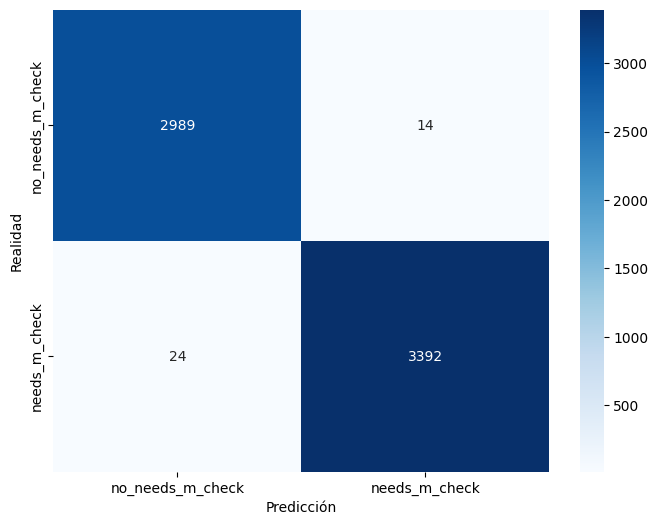

In [23]:
# Importa la función para crear la matriz de confusión
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate model performance
print("Accuracy:", clf.score(X_test, y_test))  # Accuracy score
print("Classification Report:\n", classification_report(y_test, predicciones))  # Classification report


# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")

In [24]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32092 entries, 0 to 32091
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                32092 non-null  float64
 1   stat_cr                32092 non-null  float64
 2   stat_fe                32092 non-null  float64
 3   amount                 32092 non-null  float64
 4   fee                    32092 non-null  float64
 5   recovery_status        32092 non-null  float64
 6   GBP_EUR                32092 non-null  float64
 7   inflation              32092 non-null  float64
 8   BTC_GBP                32092 non-null  float64
 9   unemploy_rate          32092 non-null  float64
 10  created_at_slot        32092 non-null  float64
 11  created_at_dow         32092 non-null  float64
 12  transfer_type          32092 non-null  float64
 13  charge_moment_numeric  32092 non-null  float64
dtypes: float64(14)
memory usage: 3.4 MB


In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# MODELO DE ÁRBOL DE DECISIÓN

# Dividir el dataset en entrenamiento y prueba
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de Árbol de Decisión
DT = tree.DecisionTreeClassifier()

# Entrenar el modelo con el conjunto de datos de entrenamiento
DT.fit(train_X, train_y)

# Realizar predicciones sobre el conjunto de prueba
predictions = DT.predict(test_X)


Precisión del modelo: 0.9998

Reporte de clasificación:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3003
           1       1.00      1.00      1.00      3416

    accuracy                           1.00      6419
   macro avg       1.00      1.00      1.00      6419
weighted avg       1.00      1.00      1.00      6419


Importancia de las características (ordenadas por magnitud):
recovery_status: 0.3531
stat_cr: 0.3405
stat_fe: 0.3064
user_id: 0.0000
amount: 0.0000
fee: 0.0000
GBP_EUR: 0.0000
inflation: 0.0000
BTC_GBP: 0.0000
unemploy_rate: 0.0000
created_at_slot: 0.0000
created_at_dow: 0.0000
transfer_type: 0.0000
charge_moment_numeric: 0.0000


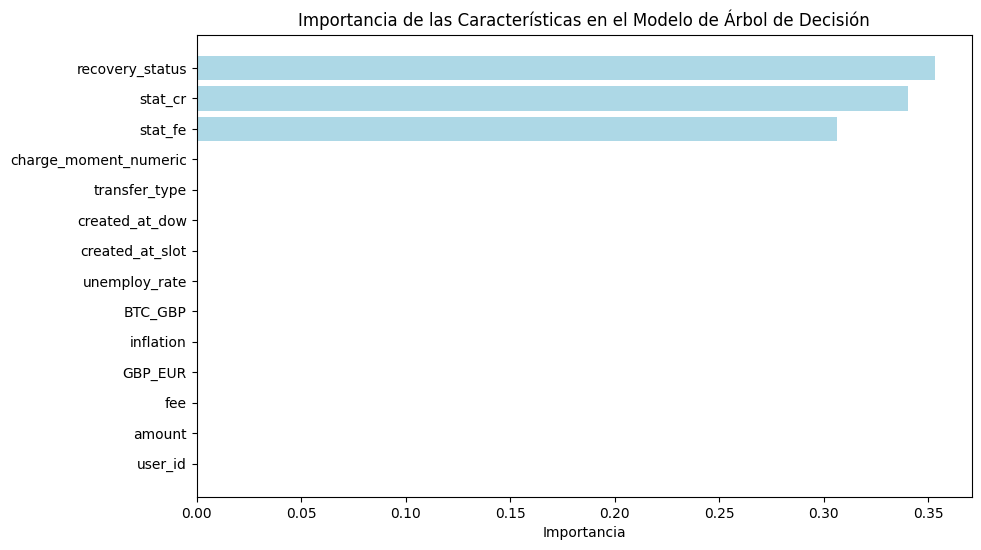

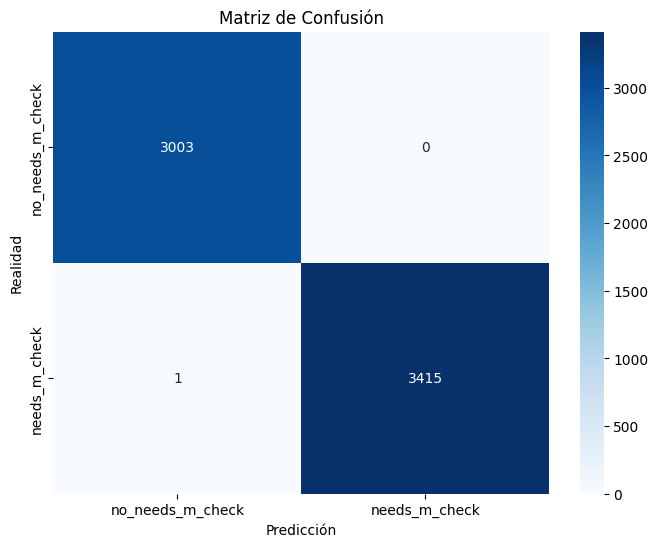

In [29]:
# Evaluación del rendimiento del modelo

# 1. Precisión del modelo
accuracy = DT.score(test_X, test_y)
print(f"Precisión del modelo: {accuracy:.4f}")  # Precisión en el conjunto de prueba

# 2. Reporte de clasificación
print("\nReporte de clasificación:\n", classification_report(test_y, predictions))  
# Muestra el reporte con métricas como precisión, recall, f1-score para cada clase

# 3. Importancia de las características

# Extraer los nombres de las características
feature_names = X.columns

# Obtener las importancias de las características del modelo
feature_importances = DT.feature_importances_

# Crear una lista de tuplas con el nombre de la característica y su importancia
feature_importance = list(zip(feature_names, feature_importances))

# Ordenar las características por la importancia en orden descendente
feature_importance_sorted = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)

# Imprimir las características ordenadas por importancia
print("\nImportancia de las características (ordenadas por magnitud):")
for feature, importance in feature_importance_sorted:
    print(f"{feature}: {importance:.4f}")

# 4. Visualización de la importancia de las características

# Graficar las importancias de las características
plt.figure(figsize=(10, 6))
features = [f[0] for f in sorted(feature_importance, key=lambda x: abs(x[1]), reverse=False)]
importances = [f[1] for f in sorted(feature_importance, key=lambda x: abs(x[1]), reverse=False)]

# Crear el gráfico de barras
plt.barh(features, importances, color='lightblue')
plt.xlabel("Importancia")
plt.title("Importancia de las Características en el Modelo de Árbol de Decisión")
plt.show()

# 5. Matriz de confusión

# Nombres de las clases para la matriz de confusión
columnas = ['no_needs_m_check', 'needs_m_check']  # 0 = No, 1 = Sí

# Visualización de la matriz de confusión con un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(test_y, predictions), annot=True, fmt='d', cmap='Blues', 
            xticklabels=columnas, yticklabels=columnas)

# Personalización de los ejes
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.title("Matriz de Confusión")
plt.show()



In [33]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Divide los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crea el modelo XGBoost
model = XGBClassifier(eval_metric='logloss')

# Entrena el modelo
model.fit(X_train, y_train)

# Realiza predicciones
y_pred = model.predict(X_test)

# Calcula la precisión
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión: {accuracy:.6f}")

Precisión: 1.000000


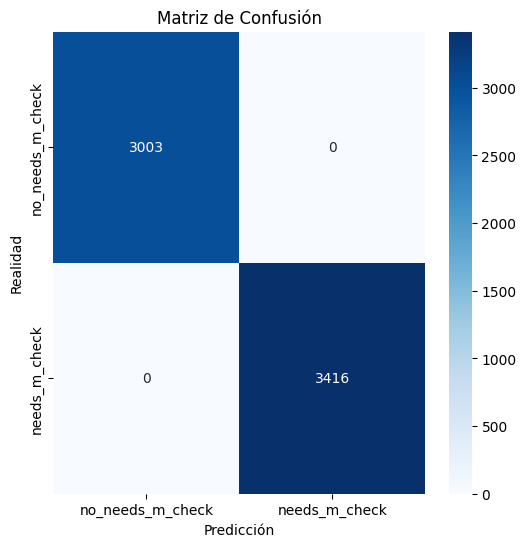

In [32]:
# Calcula la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualiza la matriz de confusión con un mapa de calor
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['no_needs_m_check', 'needs_m_check'], yticklabels=['no_needs_m_check', 'needs_m_check'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()